In [1]:
import numpy as np, pandas as pd, os
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, plot_roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import datetime

import tensorflow as tf
import tensorflow.python.util.deprecation as deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False    # no deprecation warning print

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os, glob
plt.rcParams['figure.figsize'] = [25, 15]
plt.rcParams.update({'font.size': 18})

In [2]:
dirin = "data"
ar39filename = "Ar39_{}Pileup_cut265PE.csv"
muonfilename = "MarginalMuons_wt_{}ar39_cut265PE.csv"
def load_dataset():
    # load ar39, mark various groups
    dfar39 = pd.read_csv(os.path.join(dirin, "Ar39", ar39filename.format(1)), index_col=False)
    dfar39['group'] = -1
    for i in range(2, 7+1):
        df = pd.read_csv(os.path.join(dirin, "Ar39", ar39filename.format(i)), index_col=False)        
        df['group'] = -(i)
        dfar39 = pd.concat([dfar39, df])
    # load muons, mark various groups
    dfmuons = pd.read_csv(os.path.join(dirin, "Muons", muonfilename.format(0)), index_col=False)
    dfmuons['group'] = 0
    for i in range(1, 3+1):
        df = pd.read_csv(os.path.join(dirin, "Muons", muonfilename.format(i)), index_col=False)
        df['group'] = i
        dfmuons = pd.concat([dfmuons, df])
    print("[Info] Loaded {} Ar39 events, {} Muon events.".format(len(dfar39), len(dfmuons)))
    # set boolean label
    dfar39['y'] = 0
    dfmuons['y'] = 1
    dfall = pd.concat([dfmuons, dfar39]).to_numpy()
    return dfall.reshape((dfall.shape[0], dfall.shape[1], 1))

In [3]:
def get_baseline_model(n_delta_t=1, n_slices=72):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(n_slices, n_delta_t)))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=3))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(16, activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    return model

In [4]:
def get_twoconv_model(n_delta_t=1, n_slices=72):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=6, activation='relu', input_shape=(n_slices, n_delta_t)))
    model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu'))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=3))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(16, activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    return model

In [5]:
def get_twoconv_model_forhingeloss(n_delta_t=1, n_slices=72):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=6, activation='relu', input_shape=(n_slices, n_delta_t)))
    model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu'))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=3))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(16, activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='tanh'))
    return model

In [6]:
def get_twoconv_model_wt_dropout(n_delta_t=1, n_slices=72):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=6, activation='relu', input_shape=(n_slices, n_delta_t)))
    model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=3))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(16, activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    return model

In [7]:
def print_my_confusion_matrix(g_test, y_pred):
    # Note: group <0 are ar39 (-1, -2, ..., -7), others are mu (0, 1, 2, 3)
    print("Test Set Size: {} ({} Ar39, {} Mu)".format(g_test.shape[0], g_test[g_test<0].shape[0], g_test[g_test>=0].shape[0]))
    print("\t\tPred\tPred\t| Nr")
    print("\t\tAr39\tMu\t| samples")
    print("--------------------------------------------")
    
    ar39_pred_ids = np.nonzero(y_pred.round()==0)[0]
    for i_pileup in range(1, 7 + 1):
        ar39_pileup_ids = np.nonzero(g_test==-i_pileup)[0]
        tp = len(np.intersect1d(ar39_pred_ids, ar39_pileup_ids))
        print("{} Ar39\t\t{}\t{}\t| {}".format(i_pileup, tp, len(ar39_pileup_ids)-tp, len(ar39_pileup_ids)))
    print("--------------------------------------------")
    for i_mu in range(0, 3 + 1):
        mu_pileup_ids = np.nonzero(g_test == i_mu)[0]        
        fn = len(np.intersect1d(ar39_pred_ids, mu_pileup_ids))
        print("Mu + {} Ar39\t{}\t{}\t| {}".format(i_mu, fn, len(mu_pileup_ids)-fn, len(mu_pileup_ids)))
    print("--------------------------------------------")
    print("Total\t\t{}\t{}\t| {}".format(len(ar39_pred_ids), len(y_pred)-len(ar39_pred_ids), len(y_pred)))
    

In [8]:
# Load dataset and label
all_data = load_dataset()
X, g, y = all_data[:, 2:-2], all_data[:, -2], all_data[:, -1]    # exclude edep, pedetected

[Info] Loaded 24500 Ar39 events, 25730 Muon events.


In [9]:
def repeat_train(model_generator, n_repeats=1, n_epochs=10, batch_size=32, model_name="model_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")):
    # output dir
    print("[Warning] THIS IMPLEMENTATION HAS TO BE FIXED!")
    log_dir = "logs/" + model_name 
    model_dir = "models/" + model_name
    
    # Train and test
    test_accuracy_list = []
    print("[Info] Start Train/Test of {}".format(model_name))
    for repeat in range(n_repeats):
        # Isolate test data (eval) and validation data (train)
        X_train, X_test, id_train, id_test = train_test_split(X, np.arange(0, len(y)), test_size=0.1, random_state=1234+repeat)
        y_train, y_test = y[id_train], y[id_test]
        X_train, X_dev, y_train, y_dev = train_test_split(X, y, test_size=0.1, random_state=1)
        print("[Info] Starting Repeatition {}, {} epochs".format(repeat + 1, n_epochs))
        # compile model
        model = model_generator()
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        # Callback: tensorboard and save best model
        tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=os.path.join(model_dir, "model.repeat" + str(repeat+1)), histogram_freq=1)
        modelcheckpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(model_dir, "model.repeat" + str(repeat+1) + ".epoch{epoch:02d}-valacc{val_accuracy:.5f}"),
                                                                      save_best_only=True, monitor='val_accuracy', mode='max',
                                                                      save_weights_only=False)
    
        # train
        model.fit(X_train, y_train, epochs = n_epochs, batch_size = batch_size, 
                  verbose = 0, callbacks=[tensorboard_callback, modelcheckpoint_callback], validation_data=(X_dev, y_dev))
        # test
        _, accuracy = model.evaluate(X_test, y_test, batch_size = batch_size, verbose = 1)
        test_accuracy_list.append(accuracy)
    print("[Result] Model: {}. Mean Accuracy on test set ({} repeats): {:.3f}".format(model_name, n_repeats, np.mean(test_accuracy_list)))

In [10]:
def train_once_plus_roc(X, y, model_generator, loss='binary_crossentropy', n_epochs=10, batch_size=32, model_name="model_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")):
    # output dir
    log_dir = "logs/" + model_name 
    model_dir = "models/" + model_name
    # Manage Hinge loss labels
    if 'hinge' in loss:
        y[y==0] = -1
        threshold = 0.0
    else:
        threshold = 0.5
    
    print("[Info] Loss: {}".format(loss))
    print("[Info] Label Range: {}, {}. Threshold: {}\n".format(y.min(), y.max(), threshold))
    # Train and test
    print("[Info] Start Train/Test of {}".format(model_name))
    # Isolate test data (eval) and validation data (train)
    X_train, X_test, id_train, id_test = train_test_split(X, np.arange(0, len(y)), test_size=0.1, random_state=1234)
    y_train, y_test = y[id_train], y[id_test]
    g_train, g_test = g[id_train], g[id_test]
    X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.1, random_state=1)
    print("[Info] Starting Repeatition {}, {} epochs".format(1, n_epochs))
    # compile model
    model = model_generator()
    binary_accuracy = tf.keras.metrics.BinaryAccuracy(threshold=threshold)
    model.compile(loss=loss, optimizer='adam', metrics=[binary_accuracy])
    # Callback: tensorboard and save best model
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=os.path.join(log_dir, "model.oncerepeat" + str(1)), histogram_freq=1)
    modelcheckpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(model_dir, "model.oncerepeat" + str(1) + ".epoch{epoch:02d}-valacc{val_accuracy:.5f}"),
                                                                  save_best_only=True, monitor='val_accuracy', mode='max',
                                                                  save_weights_only=False)
    
    # train
    model.fit(X_train, y_train, epochs = n_epochs, batch_size = batch_size, 
                  verbose = 2, callbacks=[tensorboard_callback], validation_data=(X_dev, y_dev))
    # test
    y_pred = model.predict(X_test)
    if "hinge" in loss:
        y_binpred = [-1 if y<0 else +1 for y in y_pred]
    else:
        y_binpred = y_pred.round()
    accuracy = accuracy_score(y_test, y_binpred)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    
    print("[Result] Model: {}. Accuracy on test set: {:.3f}".format(model_name, accuracy))
    plt.plot(fpr, tpr)
    if "hinge" in loss:
        threshold_id = np.argmin(abs(thresholds-threshold))
    else:
        threshold_id = np.argmin(abs(thresholds-threshold))
    plt.scatter(fpr[threshold_id], tpr[threshold_id], color='r', label="Threshold: {:.2f}".format(thresholds[threshold_id]))
    plt.text(.5, .5, "Training Set Size: {}, Test Set Size: {}\nAUC: {:.3f}".format(len(X_train), len(X_test), auc))
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()
    print_my_confusion_matrix(g_test, y_pred)
    return X_test, y_test, g_test, model

[PRE] Label Range: 0.0, 1.0. Threshold: ?

[Info] Loss: binary_crossentropy
[Info] Label Range: 0.0, 1.0. Threshold: 0.5

[Info] Start Train/Test of model_2conv_1maxpool_1dense_batch32_binary_crossentropy_20200604-132558
[Info] Starting Repeatition 1, 25 epochs
Epoch 1/25
1272/1272 - 5s - loss: 0.6090 - binary_accuracy: 0.6545 - val_loss: 0.6712 - val_binary_accuracy: 0.6120
Epoch 2/25
1272/1272 - 5s - loss: 0.5672 - binary_accuracy: 0.6906 - val_loss: 0.5894 - val_binary_accuracy: 0.6662
Epoch 3/25
1272/1272 - 5s - loss: 0.5469 - binary_accuracy: 0.7051 - val_loss: 0.5563 - val_binary_accuracy: 0.6861
Epoch 4/25
1272/1272 - 5s - loss: 0.5339 - binary_accuracy: 0.7112 - val_loss: 0.5365 - val_binary_accuracy: 0.7043
Epoch 5/25
1272/1272 - 5s - loss: 0.5246 - binary_accuracy: 0.7181 - val_loss: 0.5321 - val_binary_accuracy: 0.7089
Epoch 6/25
1272/1272 - 5s - loss: 0.5125 - binary_accuracy: 0.7303 - val_loss: 0.5291 - val_binary_accuracy: 0.7116
Epoch 7/25
1272/1272 - 5s - loss: 0.5045 -

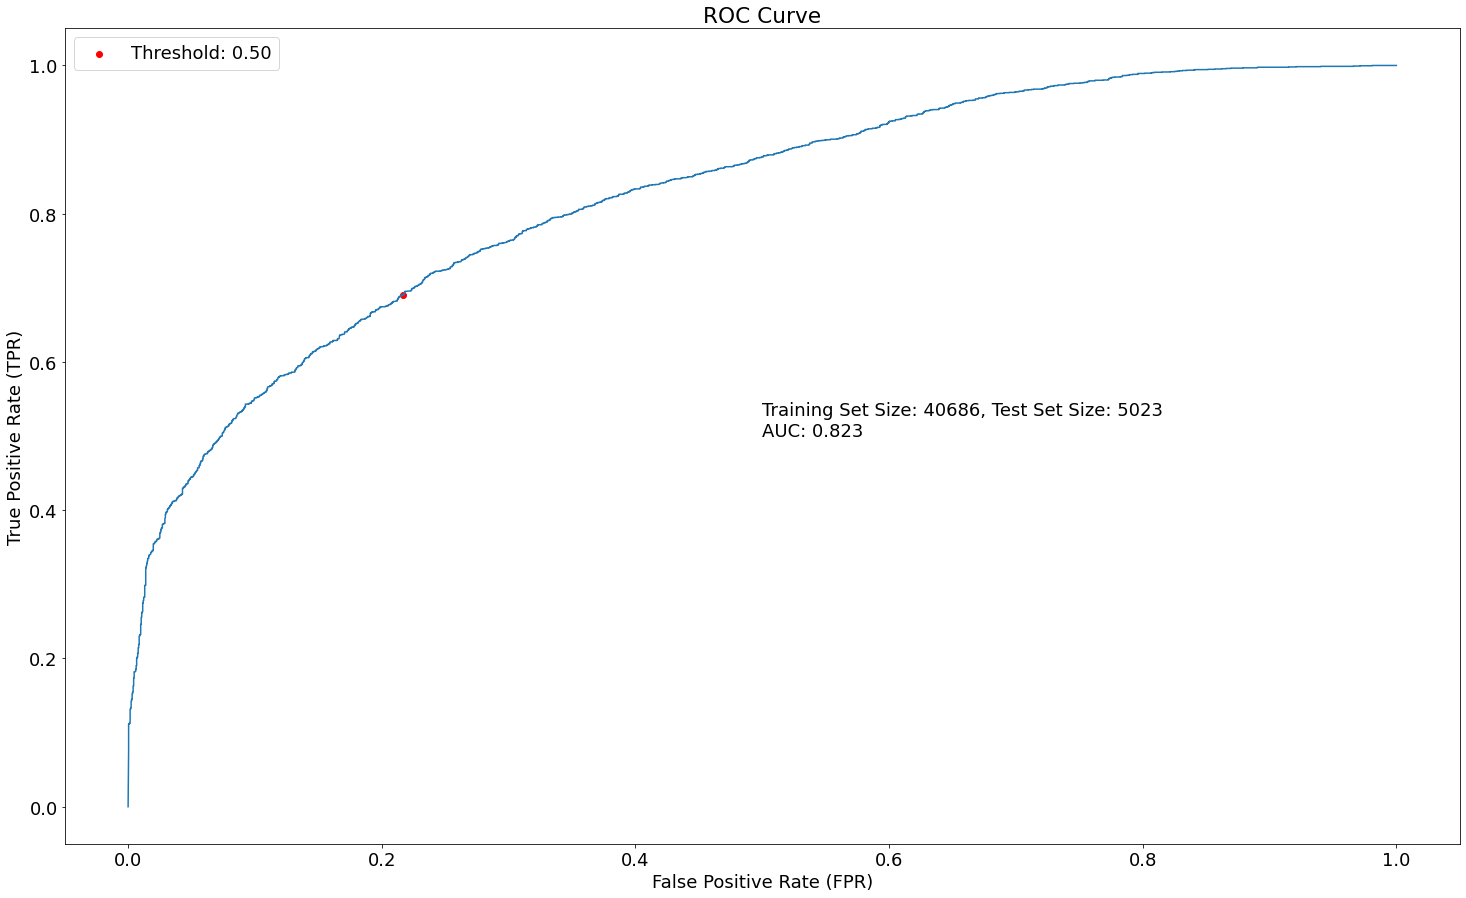

Test Set Size: 5023 (2519 Ar39, 2504 Mu)
		Pred	Pred	| Nr
		Ar39	Mu	| samples
--------------------------------------------
1 Ar39		242	93	| 335
2 Ar39		233	143	| 376
3 Ar39		254	98	| 352
4 Ar39		254	88	| 342
5 Ar39		330	58	| 388
6 Ar39		311	40	| 351
7 Ar39		348	27	| 375
--------------------------------------------
Mu + 0 Ar39	88	568	| 656
Mu + 1 Ar39	152	459	| 611
Mu + 2 Ar39	219	427	| 646
Mu + 3 Ar39	316	275	| 591
--------------------------------------------
Total		2747	2276	| 5023


In [11]:
n_repeats = 1
n_epochs = 25

# Baseline model: training, test
#model_name = "baseline_1conv_1maxpool_1dense_batch32_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#repeat_train(model_generator=get_baseline_model, n_repeats=n_repeats, n_epochs=n_epochs, model_name=model_name)

# 2Conv model: training, test
#model_name = "model_2conv_1maxpool_1dense_batch32_norm" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#repeat_train(model_generator=get_twoconv_model, n_repeats=n_repeats, n_epochs=n_epochs, model_name=model_name)

# 2Conv+Dropout model: training, test
#model_name = "model_2conv_1dropout_1maxpool_1dense_batch32_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#repeat_train(model_generator=get_twoconv_model_wt_dropout, n_repeats=n_repeats, n_epochs=n_epochs, model_name=model_name)

# 2Conv model: training, test
losses = ["binary_crossentropy"]
for loss in losses:
    X, g, y = all_data[:, 2:-2], all_data[:, -2], all_data[:, -1]    # exclude edep, pedetected
    if loss == "binary_crossentropy":
        model_gen = get_twoconv_model
    else:
        model_gen = get_twoconv_model_forhingeloss
    model_name = "model_2conv_1maxpool_1dense_batch32_" + loss + "_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    X_test, y_test, g_test, model = train_once_plus_roc(X, y, model_generator=model_gen, loss=loss, n_epochs=n_epochs, model_name=model_name)

In [ ]:
fn_id = np.intersect1d(np.nonzero(y_test==1)[0], np.nonzero(y_pred.round()==0)[0])

In [ ]:
df_test = pd.DataFrame(X_test.reshape((X_test.shape[0], X_test.shape[1])))
df_test['pedetected'] = df_test.sum(axis=1)
df_test['stddev'] = df_test.apply(lambda row: np.std(np.nonzero([row[:-1]])[1]), axis=1)
df_test['y_true'] = y_test
df_test['y_pred'] = y_pred
df_fneg = df_test.iloc[fn_id, :]

In [ ]:
bins_pe = np.linspace(0, 265, 266)
bins_std = np.linspace(0, 35, 36)
plt.subplot(2, 1, 1)
plt.hist(df_test.pedetected, bins=bins_pe, color='g')
plt.hist(df_fneg.pedetected, bins=bins_pe, color='r')
plt.subplot(2, 1, 2)
plt.hist(df_test.stddev, bins=bins_std, color='g')
plt.hist(df_fneg.stddev, bins=bins_std, color='r')
plt.show()

In [ ]:
df_test[df_test.pedetected==1].stddev.describe()

In [ ]:
row = df_test.iloc[0]


In [ ]:
row = df_test.iloc[0]

In [ ]:
np.nonzero([row[:-1]])[1]